# KNN
Here we use K Nearest Neighbors algorithm to perform classification and regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from rdkit import Chem, DataStructs
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from tqdm.notebook import tqdm

## Load Data

In [3]:
# training data:
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

# Classification

## Validation

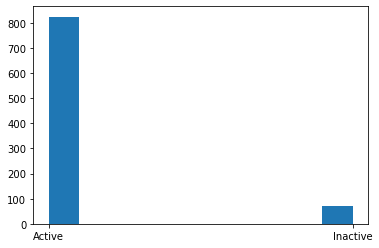

In [4]:
# set up features (X) and labels (y) for knn
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = assays.activity_target.values
assays_hist = plt.hist(y_assays)

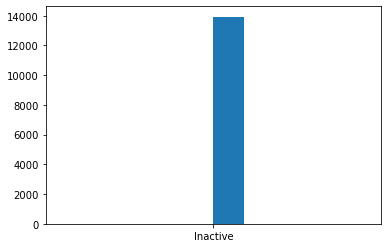

In [5]:
X_dcm = np.stack(dcm.sample(frac=.1).morgan_fingerprint)
y_dcm = ['Inactive'] * len(X_dcm)
dcm_hist = plt.hist(y_dcm)

### Validation

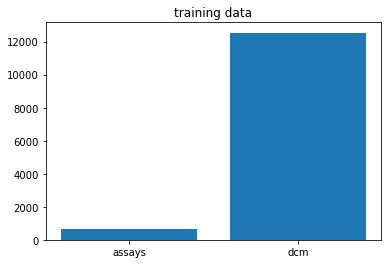

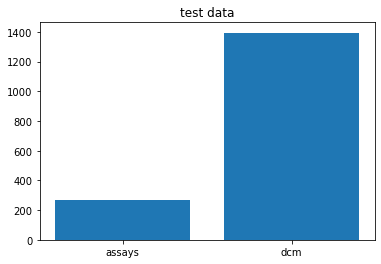

In [6]:
# make a test set out of some of the assays and some of the dcm
percent_test_assays = .3  # Make the test set a bit less skewed than the train set
percent_test_dcm = .1    #
random_state = 3 # for reproducibility of train/test split

train_X_assays, test_X_assays, train_y_assays, test_y_assays = train_test_split(X_assays, y_assays, test_size=percent_test_assays, random_state=random_state)
train_X_dcm, test_X_dcm, train_y_dcm, test_y_dcm = train_test_split(X_dcm, y_dcm, test_size=percent_test_dcm, random_state=random_state)

plt.figure()
plt.bar(['assays', 'dcm'], [len(train_X_assays), len(train_X_dcm)])
plt.title('training data')

plt.figure()
plt.bar(['assays', 'dcm'], [len(test_X_assays), len(test_X_dcm)])
plt.title('test data')

train_X = np.concatenate([train_X_assays, train_X_dcm], axis=0)
test_X = np.concatenate([test_X_assays, test_X_dcm], axis=0)
train_y = np.concatenate([train_y_assays, train_y_dcm], axis=0)
test_y = np.concatenate([test_y_assays, test_y_dcm], axis=0)

## Optimize KNN Classifier

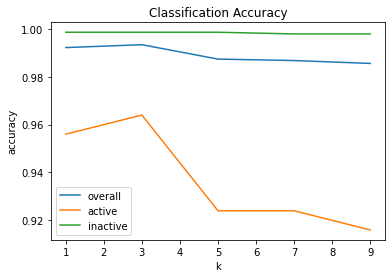

In [7]:
# optimize knn, test a couple ks

ks = np.arange(1, 10, 2)

accuracies = []
active_accuracies = []
inactive_accuracies = []
for k in tqdm(ks):
    nbrs = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree')
    nbrs.fit(train_X, train_y)
    pred = nbrs.predict(test_X)
    accuracies.append(np.count_nonzero(pred == test_y) / len(test_y))
    if np.count_nonzero(test_y == 'Inactive') == 0:
        inactive_accuracies.append(1)  # all inactive classifie correctly: vacuously true
    else:
        inactive_accuracies.append(np.count_nonzero((pred == test_y) & (pred == 'Inactive')) / np.count_nonzero(test_y == 'Inactive'))
    if np.count_nonzero(test_y == 'Active') == 0:
        active_accuracies.append(1)
    else:
        active_accuracies.append(np.count_nonzero((pred == test_y) & (test_y == 'Active')) / np.count_nonzero(test_y == 'Active'))

plt.figure()
plt.plot(ks, accuracies, label='overall')
plt.plot(ks, active_accuracies, label='active')
plt.plot(ks, inactive_accuracies, label='inactive')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title('Classification Accuracy')
plt.legend()

From the above experiment, we can see that k=3 does the best.

## Test on the Screening Data

In [11]:
# set up train and test
X_train = np.concatenate([X_assays, X_dcm])
y_train = np.concatenate([y_assays, y_dcm])

X_test = np.stack(screening_data.morgan_fingerprint)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 14827
Test set size: 21011


In [16]:
nbrs = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', n_jobs=4)
nbrs.fit(train_X, train_y)
pred = nbrs.predict(test_X)

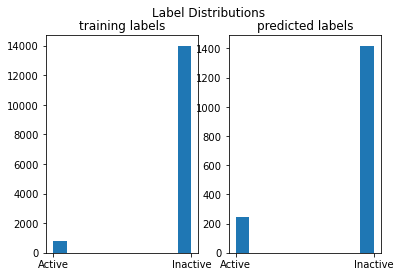

In [20]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(y_train)
ax[0].set_title('training labels')
ax[1].hist(pred)
ax[1].set_title('predicted labels')
t = plt.suptitle('Label Distributions')